In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 데이터셋 선택하기

In [4]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [5]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


# 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

In [6]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [7]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

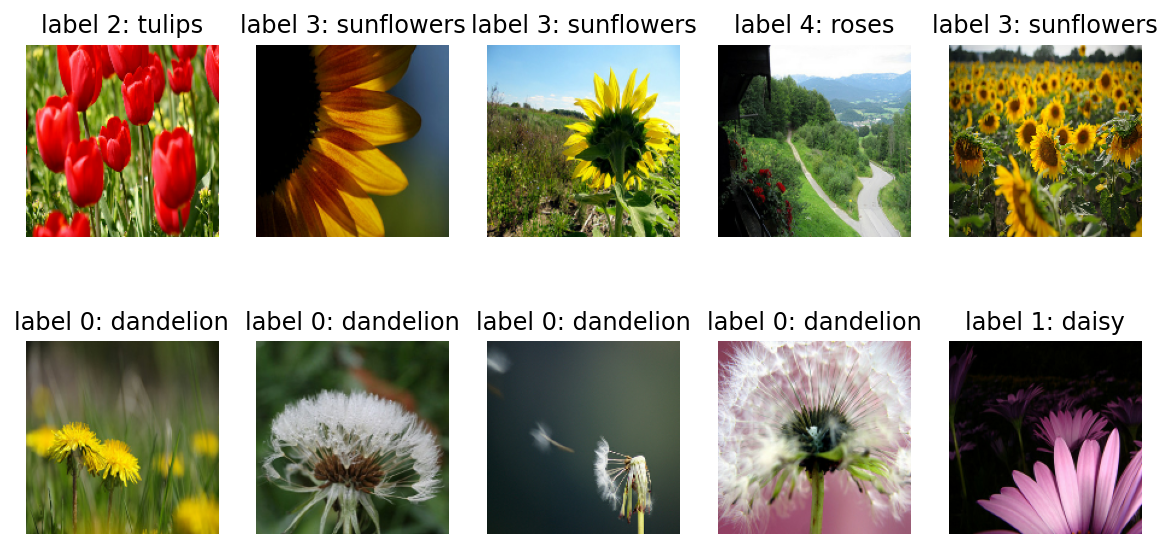

In [8]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

# 모델 설계하기

## 파라미터를 설정합니다.

In [9]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

## 전체 데이터에서 32개를 랜덤으로 뽑음

In [10]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

## train_batches에서 하나의 batch만 꺼내봄

In [11]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

## VGG16을 가져온다.

In [12]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

234553344/234545216 [==============================] - 19s 0us/step


## 넣기전 사이즈를 확인한다.

In [13]:
image_batch.shape

TensorShape([32, 160, 160, 3])

## 모델에 넣은 후 사이즈를 확인한다.

In [14]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 2048])

In [15]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 82, 82, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

## Classifier 부분을 채워준다.

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [21]:
dense_layer = tf.keras.layers.Dense(2048, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu')
dropout= tf.keras.layers.Dropout(0.2)
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [22]:
#prediction_batch = prediction_layer(dense_layer(dropout(feature_batch_average))) 

In [23]:
base_model.trainable = False

In [24]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  dropout,
  dense_layer,
  dropout,
  prediction_layer
])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 5, 5, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 10245     
Total params: 62,538,245
Trainable params: 4,206,597
Non-trainable params: 58,331,648
_________________________________________________________________


# 모델 학습시키기

## 모델 컴파일 하기

In [26]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Nadam(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

## 학습시키기

In [27]:
EPOCHS = 20

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/20
92/92 [==============================] - 119s 1s/step - loss: 2.7355 - accuracy: 0.7439 - val_loss: 2.4849 - val_accuracy: 0.8447
Epoch 2/20
92/92 [==============================] - 13s 136ms/step - loss: 2.3525 - accuracy: 0.8699 - val_loss: 2.3374 - val_accuracy: 0.8638
Epoch 3/20
92/92 [==============================] - 13s 137ms/step - loss: 2.1846 - accuracy: 0.9261 - val_loss: 2.3124 - val_accuracy: 0.8719
Epoch 4/20
92/92 [==============================] - 13s 138ms/step - loss: 2.0732 - accuracy: 0.9489 - val_loss: 2.2569 - val_accuracy: 0.8856
Epoch 5/20
92/92 [==============================] - 13s 143ms/step - loss: 1.9840 - accuracy: 0.9697 - val_loss: 2.2036 - val_accuracy: 0.8747
Epoch 6/20
92/92 [==============================] - 13s 141ms/step - loss: 1.9065 - accuracy: 0.9745 - val_loss: 2.2028 - val_accuracy: 0.8610
Epoch 7/20
92/92 [==============================] - 13s 145ms/step - loss: 1.8284 - accuracy: 0.9833 - val_loss: 2.1277 - val_accuracy: 0.8910
E

# 모델 성능 평가하기 

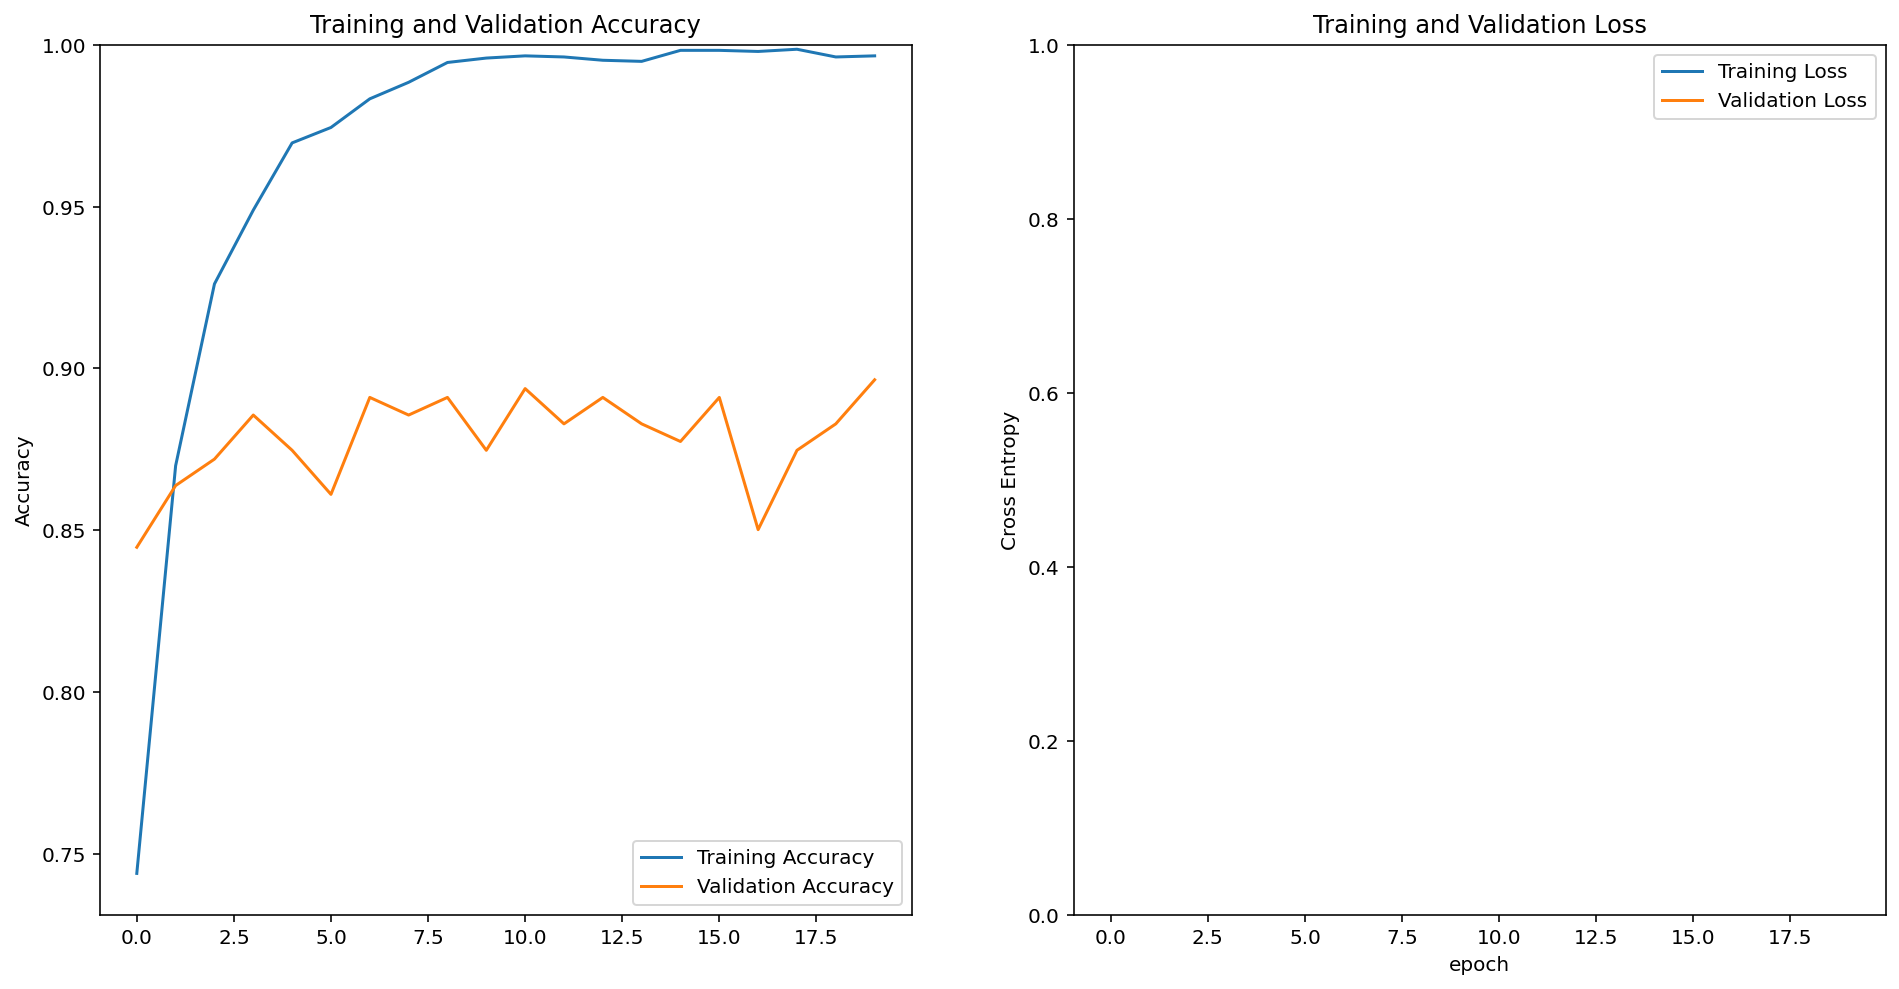

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[9.01387684e-05, 3.05966870e-03, 9.78324950e-01, 1.01285448e-04,
        1.84240211e-02],
       [1.00000000e+00, 9.92640413e-19, 4.54046262e-19, 2.44018545e-16,
        3.77129409e-17],
       [7.65246868e-01, 1.23817255e-04, 7.12659815e-03, 2.26945281e-01,
        5.57439402e-04],
       [2.71001372e-08, 1.85188856e-06, 9.99998093e-01, 1.82812734e-08,
        3.45399052e-08],
       [9.99996662e-01, 2.69124234e-06, 1.82405415e-07, 2.22486605e-07,
        2.57346727e-07],
       [9.99774635e-01, 3.64013831e-05, 1.63707773e-06, 1.85799116e-04,
        1.55320333e-06],
       [1.00565160e-06, 2.26338652e-05, 9.99884367e-01, 7.67064921e-05,
        1.52301745e-05],
       [4.14459974e-01, 5.84545255e-01, 1.91982281e-07, 9.84248007e-04,
        1.03790526e-05],
       [3.28151765e-03, 3.21488296e-05, 2.96620908e-03, 9.93691683e-01,
        2.83988793e-05],
       [1.00000000e+00, 1.89137924e-11, 6.35261158e-14, 9.33328415e-12,
        4.40056935e-10],
       [9.28975999e-01, 1.7920

In [31]:
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       0, 0, 1, 3, 2, 2, 4, 3, 0, 4])

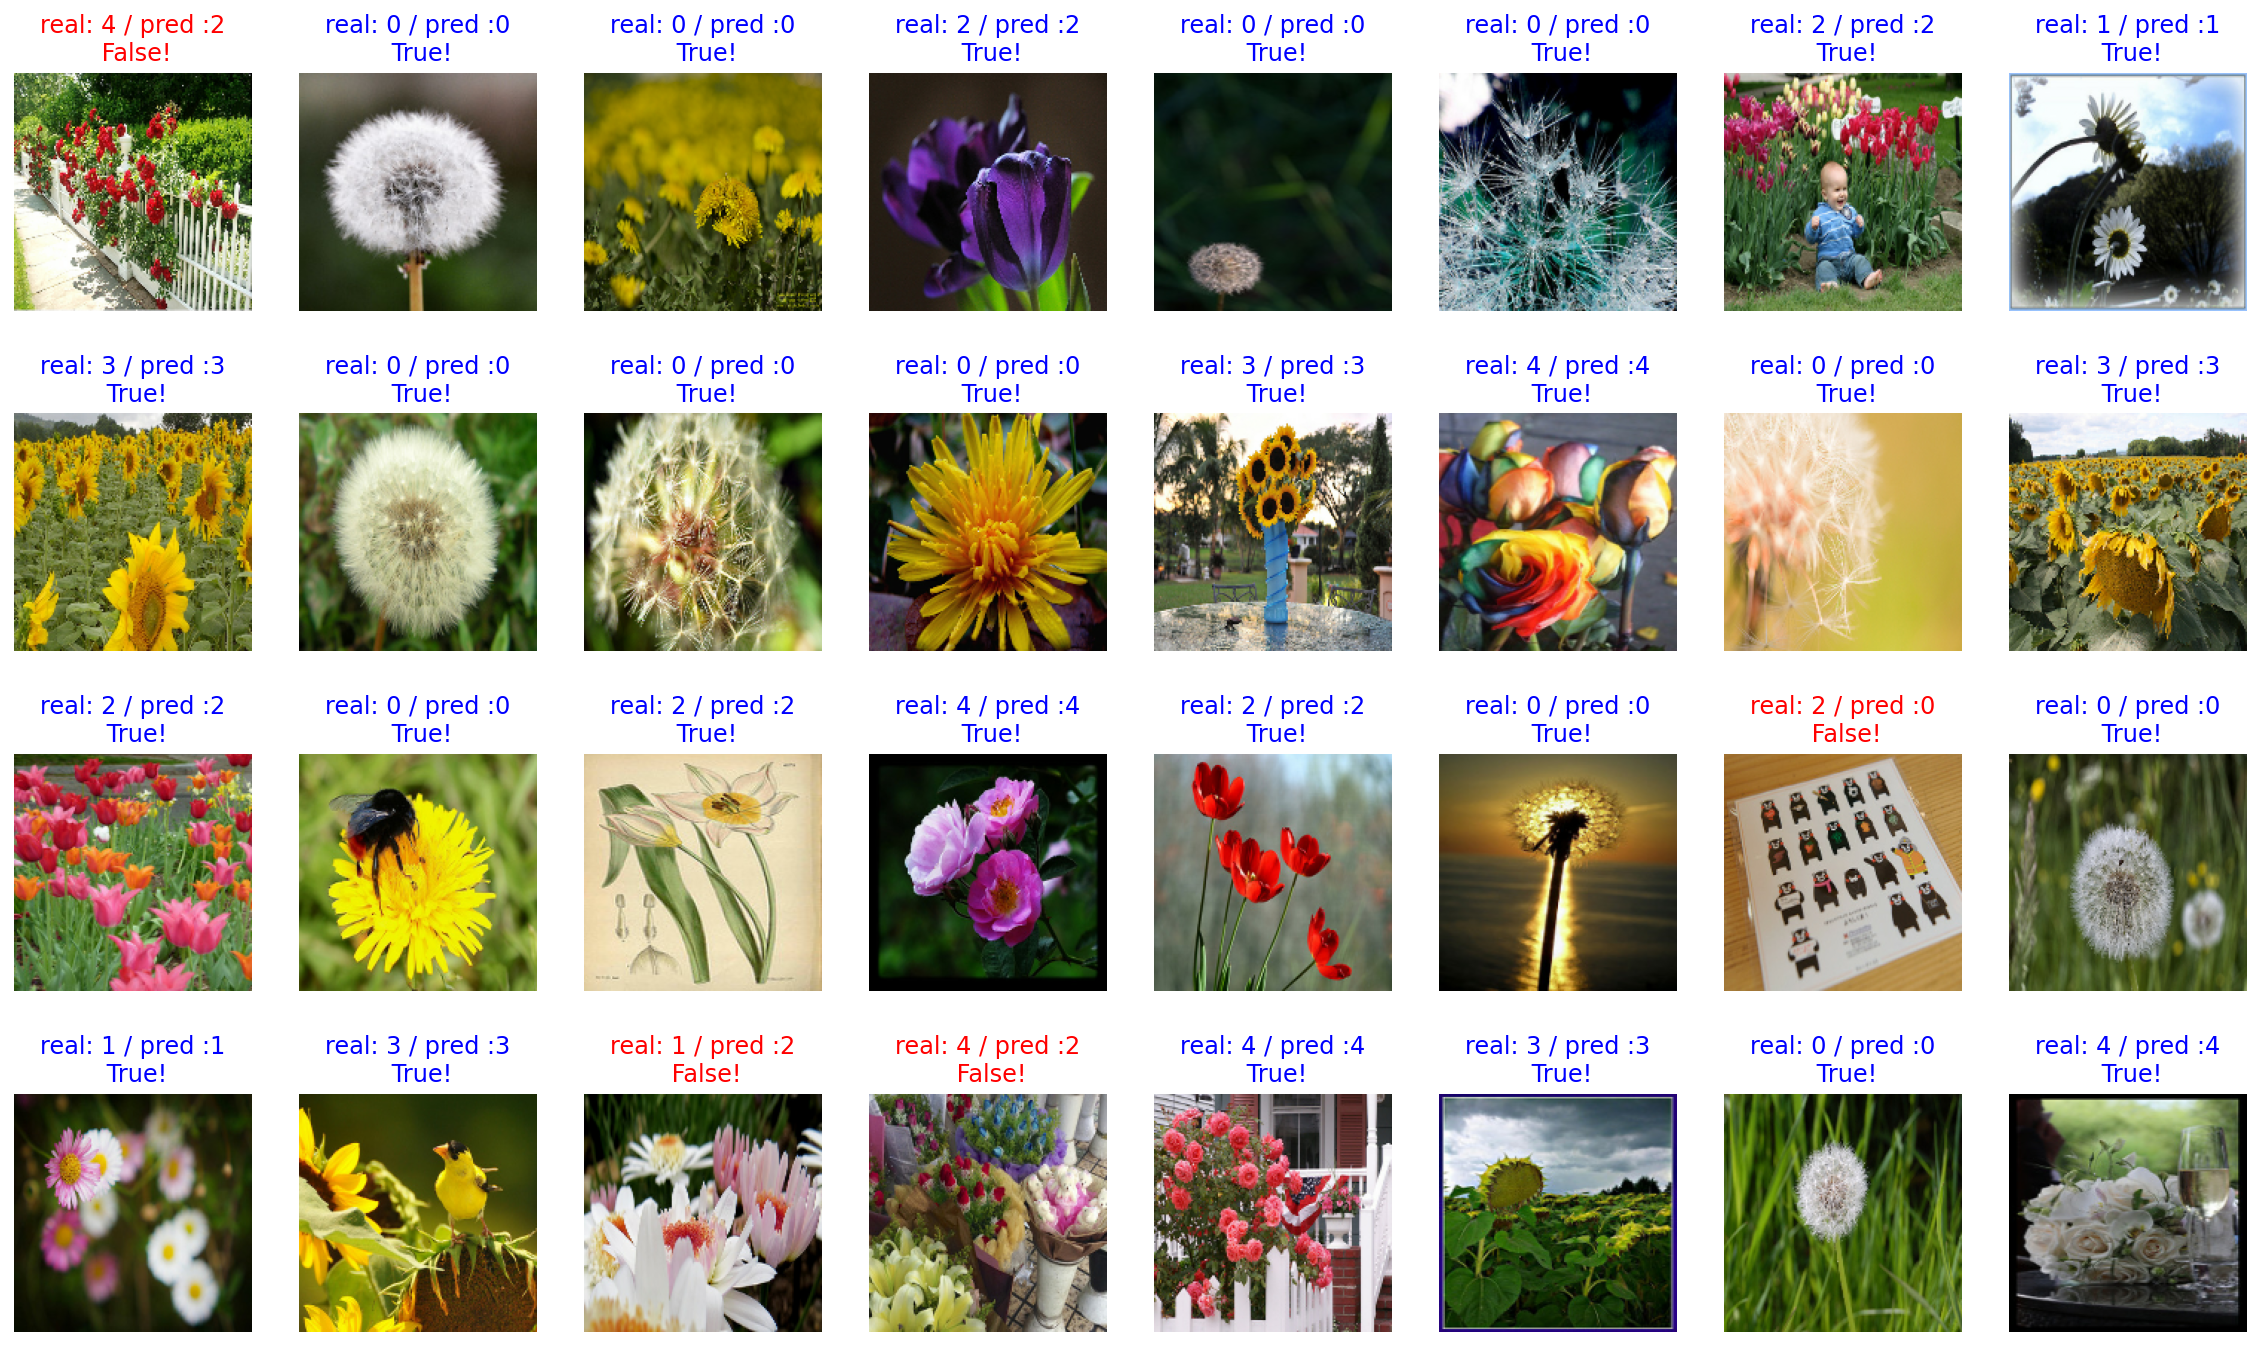

In [32]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [33]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외

87.5


# 모델 활용하기 

# 마무리

## 기본 결과

![image.png](../../data/img/pig1.png)

위의 그래프는 개선 내용의 기준이 되는 그래프입니다.  
현재 결과는 accuracy: 0.7929, val_accuracy: 0.7575로 80%를 넘지 못합니다.  
그래서 정확도를 높이기 위한 방법을 실험적으로 찾아보았습니다.  
그리고 알게 된 사실이 커널을 새로 시작하면 결과가 바뀐다는 것이 었습니다.  
그래서 변경 사항이 추가될 때 마다 커널을 Restart 했습니다.  

## 파라미터 변경

### epoch = 10의 경우

![image.png](../../data/img/pig2.png)

epoch을 10으로 늘렸더니 성능이 개선 됨이 보였습니다.  
결과는 accuracy: 0.8283 val_accuracy: 0.7956 입니다.  

## 드랍아웃 적용

### epoch = 10인 경우

![image.png](../../data/img/pig3.png)

epoch이 10인 경우 Dense layer 사이에 dropout(0.2)를 적용 했더니 생각보다 눈에 뛰는 결과는 아니었습니다.      하지만 epoch의 수를 늘린다면 더 좋은 성능을 얻을 것 이라는 생각을 했습니다.  
결과는 accuracy: 0.8096, val_accuracy: 0.7956입니다.

### epoch = 20인 경우

![image.png](../../data/img/pig4.png)

epoch를 20으로 늘린 결과 점점 정확도가 증가하는게 보였습니다.  
드롭아웃을 적용해서 그런지 Overfitting이 되지 않고  
학습 횟수가 높을 수록 좋은 성능을 낸다는 것을 알게되었습니다.  
결과는 accuracy: 0.8542 , val_accuracy: 0.8256 이었습니다.    
최종 모델에서는 에폭을 20으로 늘려보기로 결정 했습니다.  

## Optimizer 변경

### Adam의 경우

![image.png](../../data/img/pig5.png)

생각보다 결과가 좋지 않았았습니다.   
결과는 accuracy: 0.7759, val_accuracy: 0.7520 입니다.

### Nadam의 경우

![image.png](../../data/img/pig6.png)

결과는 accuracy: 0.7844, val_accuracy: 0.7711으로 기존 모델보다 조금 좋아보입니다.  
최종 모델에서는 Nadam을 사용하겠습니다.  

## L2 regularization 적용

![image.png](../../data/img/pig7.png)

Dense 레이어에 L2 regularization을 적용시켰습니다.  
결과는 accuracy: 0.7779, val_accuracy: 0.7684로 기존 모델보다 조금 좋아졌습니다.

## Dense layer 추가

![image.png](../../data/img/pig8.png)

결과는 accuracy: 0.7943, val_accuracy: 0.7629로 기존 모델보다 조금 좋아졌습니다.  
이것도 결과 모델에 추가할 것입니다.  

## VGG16 최종 모델

![image.png](../../data/img/pig9.png)

결과는 accuracy: 0.8590, val_accuracy: 0.8365 상당한 발전을 이뤄냈습니다.  
다른 모델을 쓰면 어떻게 되는 지도 궁금해 졌습니다.  

## VGG19 최종 모델

![image.png](../../data/img/pig10.png)

결과는 accuracy: 0.8392 - val_loss: 0.8574 - val_accuracy: 0.8256이다.  
성능은 괜찮았지만 아래 사진을 보면 성능을 많이 잡아 먹는 것을 볼 수 있다.

![image.png](../../data/img/pig11.png)

## ResNet50 최종 모델

![image.png](../../data/img/pig12.png)

결과는 accuracy: 0.6625, val_accuracy: 0.6213이고 생각보다 성능이 좋지 않았다.  
하지만 학습 속도는 VGG16보다 좋았다.  

## ResNet152V2 최종 모델

![image.png](../../data/img/pig13.png)

결과는 accuracy: 0.9966, val_accuracy: 0.8965 이다.   
이전 모델 중에서는 가장 좋은 성능이지만, Overfitting 된 모습이 확연하게 드러난다.  
앞으로는 이 Overfitting 문제를 어떻게 해결할 것인가에 초점을 맞춰야겠다.  